In [11]:
import gizmo_analysis as gizmo
import h5py
import halo_analysis as halo
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.interpolate as interp
import scipy.signal as signal
import utilities as ut
from gc_utils import iteration_name  # type: ignore


In [12]:
sim = "m12i"
sim_dir = "/Users/z5114326/Documents/simulations/"
fire_dir = sim_dir + sim + "/" + sim + "_res7100"

proc_file = sim_dir + sim + "/" + sim + "_processed.hdf5"
proc_data = h5py.File(proc_file, "r")  # open processed data file

snap = fire_dir + "/snapshot_times.txt"
snap_data = pd.read_table(snap, comment="#", header=None, sep=r"\s+")
snap_data.columns = [
    "index",
    "scale_factor",
    "redshift",
    "time_Gyr",
    "lookback_time_Gyr",
    "time_width_Myr",
]


In [13]:
halt = halo.io.IO.read_tree(simulation_directory=fire_dir, assign_hosts_rotation=True)


# in utilities.simulation.Snapshot():
* reading:  Users/z5114326/Documents/simulations/m12i/m12i_res7100/snapshot_times.txt

* read 17859038 halos from:  Users/z5114326/Documents/simulations/m12i/m12i_res7100/halo/rockstar_dm/catalog_hdf5/tree.hdf5


# in gizmo_analysis.gizmo_track.ParticleCoordinate():
  read 1 host (position, velocity, principal axes) from:  Users/z5114326/Documents/simulations/m12i/m12i_res7100/track/host_coordinates.hdf5
  host1 position = (41792.15, 44131.23, 46267.68) [kpc comoving]
  host1 velocity = (-52.2, 73.6, 94.7) [km/s]
  host1 axis ratios = (0.16, 0.16, 0.99)


In [14]:
grp_lst = proc_data["it000"]["snapshots"]["snap600"]["group_id"][()]

unique_values, counts = np.unique(grp_lst, return_counts=True)
grp_unq = [grp for grp, cnts in zip(unique_values, counts) if cnts > 5]
grp_unq = grp_unq[1:]  # exclude grp = 0

# get colours for groups
num_groups = len(grp_unq)
cmap = plt.get_cmap("tab20b")
colors = [cmap(i / (num_groups - 1) if num_groups > 1 else 0.5) for i in range(num_groups)]

# Create a dictionary mapping group_id to color
group_colors = {group_id: colors[i] for i, group_id in enumerate(grp_unq)}

In [15]:
def get_smoothed_values(grp_id: int, pos_threshold: float, window_length: int, polyorder: int, halt):
    km_convert = 3.086e16
    time_convert = (10e9) * 365.25 * 24 * 60 * 60

    idx = np.where(halt["tid"] == grp_id)[0][0]
    init_snap = halt["snapshot"][idx]

    next_idx = halt["descendant.index"][idx]
    # halt.prop("host.distance", next_idx), halt.prop("snapshot", next_idx)

    time = snap_data[snap_data["index"] == init_snap]["time_Gyr"].values[0]
    approx_end_time = time - 1

    end_idx = np.argmin(np.abs(approx_end_time - snap_data["time_Gyr"]))
    end_snap = snap_data["index"][end_idx]

    evolve_dict = {}
    evolve_dict[str(grp_id)] = {}

    evolve_dict[str(grp_id)]["snap"] = []
    evolve_dict[str(grp_id)]["pos"] = []
    evolve_dict[str(grp_id)]["vel"] = []

    # put final data in
    evolve_dict[str(grp_id)]["snap"].append(halt.prop("snapshot", next_idx))
    evolve_dict[str(grp_id)]["pos"].append(halt.prop("host.distance", next_idx))
    evolve_dict[str(grp_id)]["vel"].append(halt.prop("host.velocity", next_idx))

    # put init data in
    evolve_dict[str(grp_id)]["snap"].append(init_snap)
    evolve_dict[str(grp_id)]["pos"].append(halt.prop("host.distance", idx))
    evolve_dict[str(grp_id)]["vel"].append(halt.prop("host.velocity", idx))

    for _ in range(end_snap, init_snap + 1):
        idx = halt["progenitor.main.index"][idx]

        evolve_dict[str(grp_id)]["snap"].append(halt["snapshot"][idx])
        evolve_dict[str(grp_id)]["pos"].append(halt.prop("host.distance", idx))
        evolve_dict[str(grp_id)]["vel"].append(halt.prop("host.velocity", idx))

    x_lst = np.array(evolve_dict[str(grp_id)]["pos"])[:, 0]
    y_lst = np.array(evolve_dict[str(grp_id)]["pos"])[:, 1]
    z_lst = np.array(evolve_dict[str(grp_id)]["pos"])[:, 2]

    vx_lst = np.array(evolve_dict[str(grp_id)]["vel"])[:, 0]
    vy_lst = np.array(evolve_dict[str(grp_id)]["vel"])[:, 1]
    vz_lst = np.array(evolve_dict[str(grp_id)]["vel"])[:, 2]

    time_lst = np.array([snap_data["time_Gyr"][idx] for idx in evolve_dict[str(grp_id)]["snap"]])

    # Step 1: Sort by time
    sorted_indices = np.argsort(time_lst)

    # Step 2: Reorder data arrays based on sorted indices
    x_lst = x_lst[sorted_indices]
    y_lst = y_lst[sorted_indices]
    z_lst = z_lst[sorted_indices]

    vx_lst = vx_lst[sorted_indices]
    vy_lst = vy_lst[sorted_indices]
    vz_lst = vz_lst[sorted_indices]

    time_lst = time_lst[sorted_indices]

    # Arrays to store smoothed data

    x_smooth_all = []
    y_smooth_all = []
    z_smooth_all = []

    # Piecewise fitting
    for i in range(1, len(x_lst)):
        # Get the previous and current points
        pos_init = np.array([x_lst[i - 1], y_lst[i - 1], z_lst[i - 1]])
        vel_init = np.array([vx_lst[i - 1], vy_lst[i - 1], vz_lst[i - 1]])
        t_init = time_lst[i - 1]

        pos_final = np.array([x_lst[i], y_lst[i], z_lst[i]])
        vel_final = np.array([vx_lst[i], vy_lst[i], vz_lst[i]])
        t_final = time_lst[i]

        # this is in kpc
        dpos = np.abs(np.linalg.norm(pos_init) - np.linalg.norm(pos_final))

        pos_init = pos_init * km_convert
        pos_final = pos_final * km_convert
        t_init = t_init * time_convert
        t_final = t_final * time_convert

        # Construct arrays of time, position, and velocity
        t = np.array([t_init, t_final])

        x_pos = np.array([pos_init[0], pos_final[0]])
        y_pos = np.array([pos_init[1], pos_final[1]])
        z_pos = np.array([pos_init[2], pos_final[2]])

        vx_pos = np.array([vel_init[0], vel_final[0]])  # Velocities for x and y
        vy_pos = np.array([vel_init[1], vel_final[1]])
        vz_pos = np.array([vel_init[2], vel_final[2]])

        # Decide whether to use quadratic or cubic spline
        if dpos < pos_threshold:
            # Use quadratic spline (PCHIP) if velocity change is small
            cs_x = interp.CubicSpline(t, x_pos, bc_type="natural")  # For X position
            cs_y = interp.CubicSpline(t, y_pos, bc_type="natural")  # For Y position
            cs_z = interp.CubicSpline(t, z_pos, bc_type="natural")  # For Z position

            sample_step = 1
        else:
            # Use cubic spline if velocity change is large
            cs_x = interp.CubicSpline(t, x_pos, bc_type=((1, vx_pos[0]), (1, vx_pos[1])))  # For X position
            cs_y = interp.CubicSpline(t, y_pos, bc_type=((1, vy_pos[0]), (1, vy_pos[1])))  # For Y position
            cs_z = interp.CubicSpline(t, z_pos, bc_type=((1, vz_pos[0]), (1, vz_pos[1])))  # For Z position

            sample_step = 10

        # Generate smooth interpolated points for the current segment
        t_smooth = np.linspace(t_init, t_final, sample_step)  # More points for smoothing

        x_smooth = cs_x(t_smooth)
        y_smooth = cs_y(t_smooth)
        z_smooth = cs_z(t_smooth)

        # Append smooth points to the lists
        x_smooth_all.extend(x_smooth)
        y_smooth_all.extend(y_smooth)
        z_smooth_all.extend(z_smooth)

    x_all_con = np.array(x_smooth_all) / km_convert
    y_all_con = np.array(y_smooth_all) / km_convert
    z_all_con = np.array(z_smooth_all) / km_convert

    x_plt = signal.savgol_filter(x_all_con, window_length, polyorder)
    y_plt = signal.savgol_filter(y_all_con, window_length, polyorder)
    z_plt = signal.savgol_filter(z_all_con, window_length, polyorder)

    smooth_dict = {"base": {}, "plot": {}}
    smooth_dict["base"] = {"x": x_lst, "y": y_lst, "z": z_lst}
    smooth_dict["plot"] = {"x": x_plt, "y": y_plt, "z": z_plt}

    return smooth_dict

In [16]:
def get_kinematics(grp_id, halt):
    idx = np.where(halt["tid"] == grp_id)[0][0]
    init_snap = halt["snapshot"][idx]

    next_idx = halt["descendant.index"][idx]
    acc_snap = halt["snapshot"][next_idx]
    time_accrete = snap_data[snap_data["index"] == acc_snap]["time_Gyr"].values[0]

    time = snap_data[snap_data["index"] == init_snap]["time_Gyr"].values[0]
    approx_end_time = time - 1

    start_idx = np.argmin(np.abs(approx_end_time - snap_data["time_Gyr"]))
    start_snap = snap_data["index"][start_idx]

    kin_dict = {}
    kin_dict["time"] = []
    kin_dict["acc_time"] = []

    kin_dict["r"] = []

    kin_dict["lx"] = []
    kin_dict["ly"] = []
    kin_dict["lz"] = []

    kin_dict["l"] = []
    kin_dict["ek"] = []

    for _ in range(start_snap, acc_snap + 1):
        idx = halt["progenitor.main.index"][idx]
        snap = halt["snapshot"][idx]
        time = snap_data[snap_data["index"] == snap]["time_Gyr"].values[0]
        acc_time = time - time_accrete

        # x, y, z = halt.prop("host.distance", idx)
        # vx, vy, vz = halt.prop("host.velocity", idx)

        x, y, z = halt.prop("host.distance.principal", idx)
        vx, vy, vz = halt.prop("host.velocity.principal", idx)

        r = np.linalg.norm([x, y, z])

        lx = y * vz - z * vy
        ly = z * vx - x * vz
        lz = x * vy - y * vx

        l = np.linalg.norm([lx, ly, lz])

        ek = 0.5 * (vx**2 + vy**2 + vz**2)

        kin_dict["time"].append(time)
        kin_dict["acc_time"].append(acc_time)

        kin_dict["r"].append(r)

        kin_dict["lx"].append(lx)
        kin_dict["ly"].append(ly)
        kin_dict["lz"].append(lz)

        kin_dict["l"].append(l)
        kin_dict["ek"].append(ek)

    return kin_dict

In [17]:
pos_thresh = 7.5
window = 12
polyorder = 3

res_dict = {grp_id: get_smoothed_values(grp_id, pos_thresh, window, polyorder, halt) for grp_id in grp_unq}
kin_dict = {grp_id: get_kinematics(grp_id, halt) for grp_id in grp_unq}

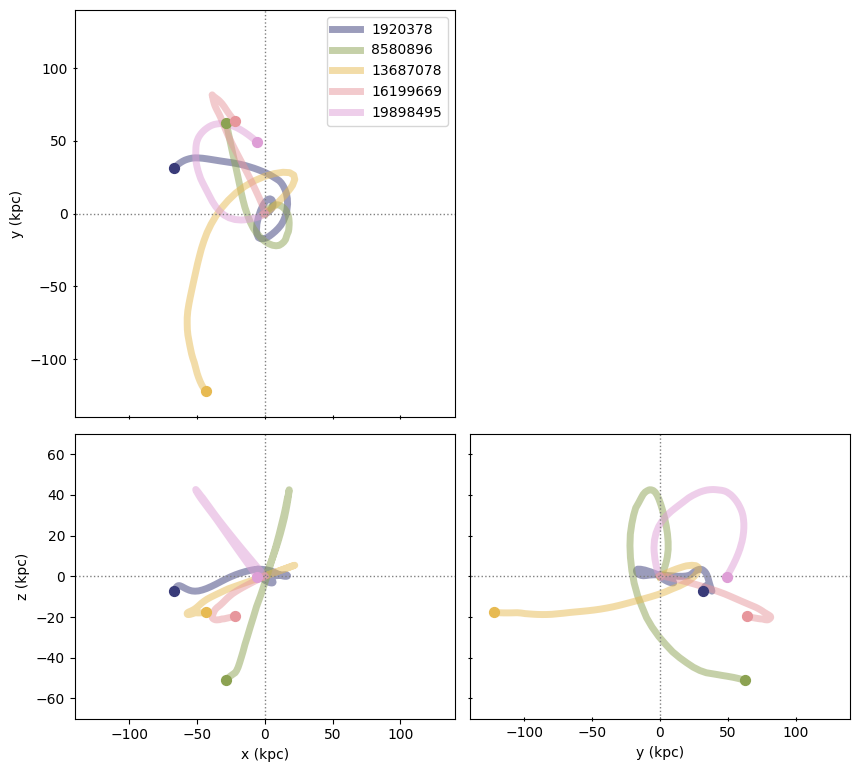

In [18]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

for grp in res_dict.keys():
    x_base = res_dict[grp]["base"]["x"]
    y_base = res_dict[grp]["base"]["y"]
    z_base = res_dict[grp]["base"]["z"]

    x_plot = res_dict[grp]["plot"]["x"]
    y_plot = res_dict[grp]["plot"]["y"]
    z_plot = res_dict[grp]["plot"]["z"]

    axs[0, 0].scatter(x_plot[0], y_plot[0], color=group_colors[grp], s=50, zorder=10)
    axs[1, 0].scatter(x_plot[0], z_plot[0], color=group_colors[grp], s=50, zorder=10)
    axs[1, 1].scatter(y_plot[0], z_plot[0], color=group_colors[grp], s=50, zorder=10)

    axs[0, 0].plot(x_plot, y_plot, c=group_colors[grp], lw=5, ls="-", alpha=0.5, label=str(grp))
    axs[1, 0].plot(x_plot, z_plot, c=group_colors[grp], lw=5, ls="-", alpha=0.5)
    axs[1, 1].plot(y_plot, z_plot, c=group_colors[grp], lw=5, ls="-", alpha=0.5)

    # axs[1, 1].plot(y_base, z_base, "o-")

axs[0, 1].axis("off")

lim00x = 140
lim00y = 140

axs[0, 0].plot([-lim00x, lim00x], [0, 0], c="grey", ls=":", lw=1)
axs[0, 0].plot([0, 0], [-lim00y, lim00y], c="grey", ls=":", lw=1)
axs[0, 0].set_xlim([-lim00x, lim00x])
axs[0, 0].set_ylim([-lim00y, lim00y])
axs[0, 0].set_ylabel("y (kpc)")

lim01x = 140
lim01y = 70

axs[1, 0].plot([-lim01x, lim01x], [0, 0], c="grey", ls=":", lw=1)
axs[1, 0].plot([0, 0], [-lim01y, lim01y], c="grey", ls=":", lw=1)
axs[1, 0].set_xlim([-lim01x, lim01x])
axs[1, 0].set_ylim([-lim01y, lim01y])
axs[1, 0].set_xlabel("x (kpc)")
axs[1, 0].set_ylabel("z (kpc)")

lim11x = 140
lim11y = 70

axs[1, 1].plot([-lim11x, lim11x], [0, 0], c="grey", ls=":", lw=1)
axs[1, 1].plot([0, 0], [-lim11y, lim11y], c="grey", ls=":", lw=1)
axs[1, 1].set_xlim([-lim11x, lim11x])
axs[1, 1].set_ylim([-lim11y, lim11y])
axs[1, 1].set_xlabel("y (kpc)")

axs[0, 0].tick_params(axis="both", direction="inout", labelbottom=False)  # Turn off X-axis
axs[1, 1].tick_params(axis="both", direction="inout", labelleft=False)  # Turn off X-axis

# axs[0, 0].legend(bbox_to_anchor=(1.37, 1.02), alignment="left")
axs[0, 0].legend(loc="upper right")

axs[1, 0].set_aspect(aspect=1.5)
axs[1, 1].set_aspect(aspect=1.5)

fig.subplots_adjust(hspace=-0.11, wspace=0.04)


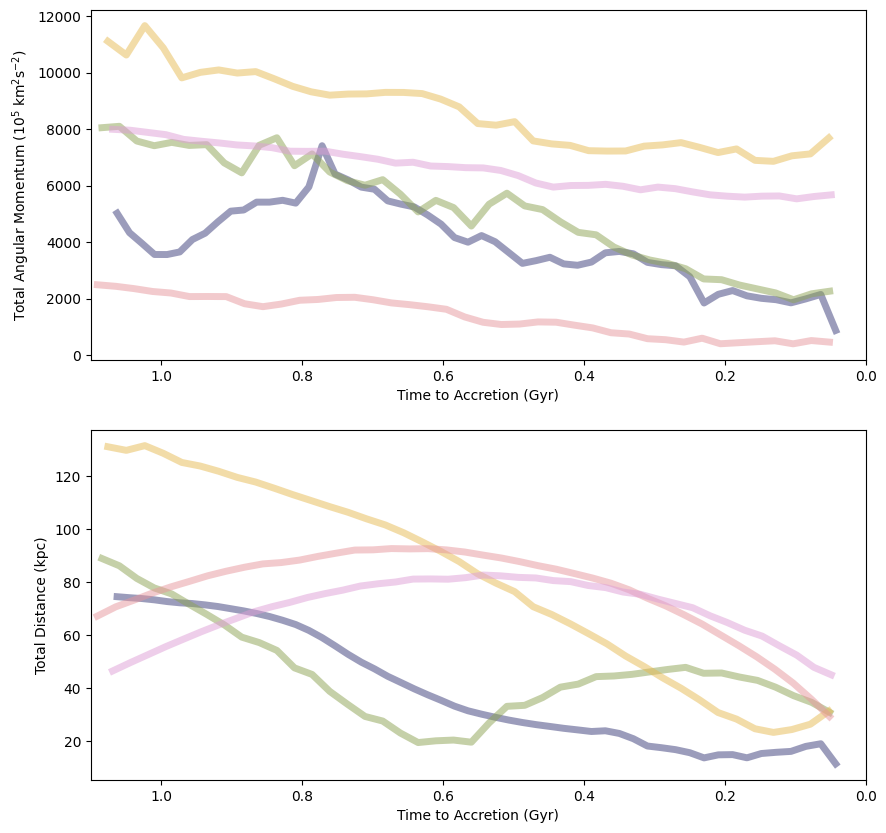

In [19]:
fig, axs = plt.subplots(2, 1, figsize=(10, 10))

for grp in kin_dict.keys():
    lx = kin_dict[grp]["lx"]
    ly = kin_dict[grp]["ly"]
    lz = kin_dict[grp]["lz"]

    l = kin_dict[grp]["l"]

    ek = kin_dict[grp]["ek"]

    r = kin_dict[grp]["r"]

    t = kin_dict[grp]["acc_time"]
    t = -np.array(t)

    axs[0].plot(t, l, c=group_colors[grp], lw=5, ls="-", alpha=0.5, label=str(grp))
    axs[1].plot(t, r, c=group_colors[grp], lw=5, ls="-", alpha=0.5, label=str(grp))

    axs[0].set_xlim(1.1, 0)
    axs[1].set_xlim(1.1, 0)

    axs[0].set_xlabel("Time to Accretion (Gyr)")
    axs[0].set_ylabel(r"Total Angular Momentum ($10^5$ km$^2$s$^{-2}$)")

    axs[1].set_xlabel("Time to Accretion (Gyr)")
    axs[1].set_ylabel(r"Total Distance (kpc)")

Can stack (average) densities (kdes) in (normalised) IOM space for each iteration. Show how the (background) density decreases over time.

Can I relate position of GCs over time with number of GCs.